# Importing python libraries

In [178]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, words, wordnet
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

# Loading data

In [6]:
url = 'https://raw.githubusercontent.com/balaramganesh/WF-ML-BATCH-HACKATHON/master/Tweets.csv'
data = pd.read_csv(url, index_col=0)

In [7]:
data.shape

(14640, 14)

In [8]:
data.describe()

,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,14640.000000,10522.000000,14640.000000
mean,0.900169,0.638298,0.082650
std,0.162830,0.330440,0.745778
min,0.335000,0.000000,0.000000
25%,0.692300,0.360600,0.000000
50%,1.000000,0.670600,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,44.000000


In [9]:
data.isna().sum() #The required columns, ie., airline_sentiment and text have no null values

airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [10]:
#Dropping all columns except the airline_sentiment and text 
arr = data.columns
arr = np.array(arr.drop(['text','airline_sentiment']))
data.drop(columns=arr,inplace=True)

In [11]:
data.shape

(14640, 2)

In [12]:
data.head()

,airline_sentiment,text
tweet_id,,
570306133677760513,neutral,@VirginAmerica What @dhepburn said.
570301130888122368,positive,@VirginAmerica plus you've added commercials t...
570301083672813571,neutral,@VirginAmerica I didn't today... Must mean I n...
570301031407624196,negative,@VirginAmerica it's really aggressive to blast...
570300817074462722,negative,@VirginAmerica and it's a really big bad thing...


In [135]:
data['airline_sentiment'].value_counts(normalize=True).sort_index() #Imbalance in the data

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

# Data Preprocessing

In [179]:
# Process folowed in data preprocessing:
# Convert all text into lowercase
# Remove the tweet symbols, eg. @VirginAtlantic
# Remove the stopwords before removing the special characters, reason being, eg., it's is tokenized as it and 's and will not be removed.
# Remove numbers and special characters
#Checking for stopwords again to remove stopwords attached to special characters/numbers during tokenization
#The above process is not exhaustive and further improvements can be made, eg. spellcheck

In [17]:
#Removing the tweet symbols (@) and converting all the text into lower case
wordnet_lemmantizer = WordNetLemmatizer()
fdist  = FreqDist()

data['airline_sentiment'] = data['airline_sentiment'].str.lower()
for i in range(len(data['text'].values)) :
    text = data['text'].values[i]
    token = word_tokenize(text)  

    #Make all alphabets lowercase
    text = text.lower()
    #Remove all tweet, eg. @VirginAtlantic, @JetBlue
    data['text'].values[i] = re.sub("@[A-Za-z0-9]+"," ",text)

    #Remove all stopwords
    text = data['text'].values[i]
    token = []
    for word in text.split():
        if word not in stopwords.words('english'):
            token.append(word)
    text = TreebankWordDetokenizer().detokenize(token)

    #Remove the numbers
    text = re.sub(r'[0-9]+',' ',text)
    #Remove special characters
    text = re.sub(r'[^A-Za-z0-9]+',' ',text)
    data['text'].values[i] = text

    #Lemmatization
    token = []
    text = data['text'].values[i]
    for word in text.split() :
        word = wordnet_lemmantizer.lemmatize(word)
        if word not in stopwords.words() :
            fdist[word] += 1
            token.append(word)
    text = TreebankWordDetokenizer().detokenize(token)
    data['text'].values[i] = text

In [23]:
#Processed Data
data.head()

,airline_sentiment,text
tweet_id,,
570306133677760513,neutral,said
570301130888122368,positive,plus added commercial experience tacky
570301083672813571,neutral,today must mean need another trip
570301031407624196,negative,really aggressive blast obnoxious entertainmen...
570300817074462722,negative,really big bad thing


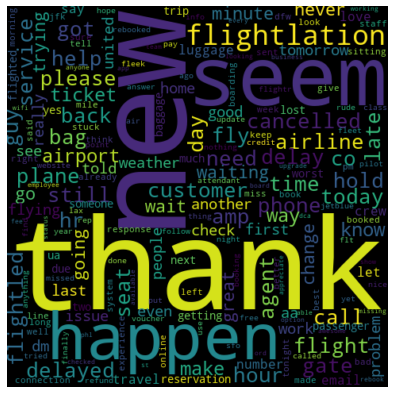

In [173]:
#WordCloud of Processed Data
text = ''
n_words = 1000
for i in range(n_words) :
    text += fdist.most_common(n_words)[i][0] + ' '
 
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
 
# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# Vectorization

In [105]:
x = data['text']
y = data['airline_sentiment']

In [96]:
#Count Vectorization
cv = CountVectorizer(stop_words='english',min_df=2)
x_cv = cv.fit_transform(x.values.astype('U'))
x_cv_df = pd.DataFrame(x_cv.toarray(),columns=cv.get_feature_names())

In [134]:
x_cv_df.head()

,aa,aadv,aadvantage,aafail,aal,abandoned,abc,abi,ability,able,...,zf,zik,zone,zoom,zq,zr,zurich,zv,zy,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
#TFIDF Vectorization
tf = TfidfVectorizer(stop_words='english',min_df=2)
x_tf = tf.fit_transform(x)
x_tf_df = pd.DataFrame(x_tf.toarray(),columns=tf.get_feature_names())

In [107]:
label_encode = LabelEncoder()
y = label_encode.fit_transform(y)

# Optimized Random Forest

In [99]:
xtrain,xtest,ytrain,ytest = train_test_split(x_cv_df,y,test_size=0.3,random_state=10)
param_grid = [ {
   'n_estimators' : list(range(100,250,50)),
    'max_features' : list(range(10,90,20)),
    'criterion' : ['entropy','gini'],
    'random_state' : [10]}
]
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid = param_grid, cv = 3, verbose=True, n_jobs=3)
best_clf = clf.fit(xtrain,ytrain)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 14.4min
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed: 25.2min finished


In [147]:
# Model is overfitting training data and this pattern follows in all upcoming models
rf_results = pd.DataFrame(best_clf.best_params_.items(),columns=['Parameters','Values'])
print('Results for Count Vectorized Data:\n')
print('Accuracy for training data :',np.round(100*best_clf.score(xtrain,ytrain),2),'%')
ypredict = best_clf.predict(xtest)
print('Accuracy for testing data :',np.round(100*accuracy_score(ytest,ypredict),2),'%')
print('\n')
print('Optimized Random Forest:')
rf_results

Results for Count Vectorized Data:

Accuracy for training data : 99.15 %
Accuracy for testing data : 75.36 %


Optimized Random Forest:


,Parameters,Values
0,criterion,entropy
1,max_features,10
2,n_estimators,100
3,random_state,10


In [148]:
#Optimized Random Forest for TFIDF dataframe
classifier = RandomForestClassifier(criterion= 'entropy',max_features= 10,n_estimators= 100,random_state= 10)
classifier.fit(xtrain,ytrain)
ypredict = classifier.predict(xtest)
print('Results for TFIDF Data:\n')
print('Accuracy for training data :',np.round(100*classifier.score(xtrain,ytrain),2),'%')
print('Accuracy for testing data :',np.round(100*accuracy_score(ytest,ypredict),2),'%')
#Accuracies were similar to count vectorized dataframe

Results for TFIDF Data:

Accuracy for training data : 99.15 %
Accuracy for testing data : 75.36 %


# Optimized Random Forest on TFIDF Dataframe with PCA

In [152]:
pca = PCA(n_components=3000)
principal_comp_tf = pca.fit_transform(x_tf_df)
print('Total explained variance in transformed data: ',np.round(100*np.sum(pca.explained_variance_ratio_),2),'%')

Total explained variance in transformed data:  95.23 %


In [153]:
principal_data = pd.DataFrame(data = principal_comp_tf, columns = np.linspace(start=1,stop=3000,num=3000))
principal_data.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,2991.0,2992.0,2993.0,2994.0,2995.0,2996.0,2997.0,2998.0,2999.0,3000.0
0,0.008218,0.018214,-0.054482,-0.022492,-0.044574,-0.002084,0.002983,-0.030789,-0.009651,-0.024714,...,0.000515,0.002232,0.001348,-0.002707,0.002069,-0.001729,-0.002243,-0.000885,0.000687,0.001973
1,0.012996,0.020487,-0.052943,-0.018440,-0.030716,0.016381,-0.002999,-0.018097,-0.020845,0.004496,...,0.000097,0.004531,-0.007356,-0.000465,0.002127,0.004032,0.000931,-0.006338,-0.002436,-0.004162
2,-0.012323,0.001312,-0.032750,-0.029458,-0.031362,0.001890,0.087773,-0.056626,0.073828,-0.024597,...,-0.001643,0.001246,0.004216,-0.001065,-0.001906,0.001535,-0.000841,-0.000641,-0.002760,-0.000423
3,0.006009,0.015397,-0.048913,-0.015055,-0.032229,-0.003181,0.002940,-0.020010,-0.013666,-0.012150,...,-0.009356,0.014464,0.002325,0.005837,0.007144,-0.008490,0.005797,0.021894,0.002890,-0.007727
4,0.012213,0.017901,-0.059420,-0.021651,-0.037825,0.009501,-0.008142,-0.024236,-0.020287,-0.005946,...,0.000309,-0.000835,0.001920,-0.000696,-0.000733,0.000982,-0.001224,-0.000240,-0.003598,0.000982


In [154]:
xtrain,xtest,ytrain,ytest = train_test_split(principal_data,y,test_size=0.3,random_state=5)
classifier = RandomForestClassifier(criterion= 'entropy',max_features= 10,n_estimators= 100,random_state= 10)
classifier.fit(xtrain,ytrain)
ypredict = classifier.predict(xtest)
print('Results for PCA reduced TFIDF Data:\n')
print('Accuracy for training data :',np.round(100*classifier.score(xtrain,ytrain),2),'%')
print('Accuracy for testing data :',np.round(100*accuracy_score(ytest,ypredict),2),'%')
#PCA reduced the accuracies compared to original data

Results for PCA reduced TFIDF Data:

Accuracy for training data : 98.82 %
Accuracy for testing data : 65.64 %


# Artificial Neural Network

In [156]:
y = to_categorical(y,3)
xtrain,xtest,ytrain,ytest = train_test_split(x_tf_df ,y,test_size=0.2,random_state=5)
nn_clf = Sequential()
nn_clf.add(Dense(activation = 'relu', input_dim = 4940, units=2000, kernel_initializer='uniform'))
nn_clf.add(Dense(500, activation='relu', kernel_initializer='uniform'))
nn_clf.add(Dense(3, activation = 'softmax', kernel_initializer='uniform')) 
nn_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_clf.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 2000)              9882000   
_________________________________________________________________
dense_69 (Dense)             (None, 500)               1000500   
_________________________________________________________________
dense_70 (Dense)             (None, 3)                 1503      
Total params: 10,884,003
Trainable params: 10,884,003
Non-trainable params: 0
_________________________________________________________________


In [88]:
history = nn_clf.fit(xtrain, ytrain,validation_data=(xtest,ytest),epochs=50,batch_size=50)

Epoch 1/50
235/235 [==============================] - 12s 49ms/step - loss: 0.0599 - accuracy: 0.9798 - val_loss: 0.8922 - val_accuracy: 0.7763
Epoch 2/50
235/235 [==============================] - 13s 57ms/step - loss: 0.0429 - accuracy: 0.9850 - val_loss: 1.0184 - val_accuracy: 0.7763
Epoch 3/50
235/235 [==============================] - 16s 67ms/step - loss: 0.0365 - accuracy: 0.9863 - val_loss: 1.0392 - val_accuracy: 0.7671
Epoch 4/50
235/235 [==============================] - 17s 72ms/step - loss: 0.0335 - accuracy: 0.9877 - val_loss: 0.9980 - val_accuracy: 0.7664
Epoch 5/50
235/235 [==============================] - 19s 81ms/step - loss: 0.0311 - accuracy: 0.9867 - val_loss: 1.0848 - val_accuracy: 0.7708
Epoch 6/50
235/235 [==============================] - 18s 77ms/step - loss: 0.0287 - accuracy: 0.9874 - val_loss: 1.2149 - val_accuracy: 0.7742
Epoch 7/50
235/235 [==============================] - 17s 73ms/step - loss: 0.0271 - accuracy: 0.9882 - val_loss: 1.1811 - val_accuracy:

Average validation accuracy:  76.69 %
Average training accuracy:  98.84 %


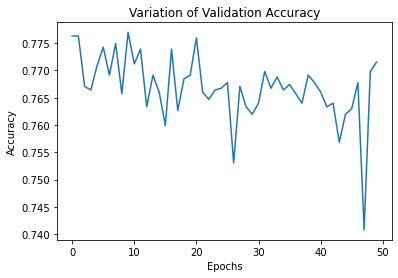

In [176]:
#Validation accuracy is showing a converging trend but is yet to reach convergence
print('Average validation accuracy: ',np.round(100*np.average(history.history['val_accuracy']),2),'%')
print('Average training accuracy: ',np.round(100*np.average(history.history['accuracy']),2),'%')
plt.figure()
plt.plot(history.history['val_accuracy'],label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Variation of Validation Accuracy')
plt.show()

# LSTM Analysis

In [130]:
max_fatures = 3000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

embed_dim = 500
lstm_out = 100

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)
lstm_history = model.fit(X_train, Y_train,validation_data=(X_test,Y_test) ,epochs = 50, batch_size=50, verbose = 2)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 21, 500)           1500000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 21, 500)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               240400    
_________________________________________________________________
dense_67 (Dense)             (None, 3)                 303       
Total params: 1,740,703
Trainable params: 1,740,703
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
197/197 - 16s - loss: 0.6785 - accuracy: 0.7153 - val_loss: 0.5336 - val_accuracy: 0.7928
Epoch 2/50
197/197 - 15s - loss: 0.4620 - accuracy: 0.8140 - val_loss: 0.5315 - val_accuracy: 0.7918
Epoch 3/50
197/197 - 17s - loss: 0

Average validation accuracy:  75.05 %
Average training accuracy:  96.08 %


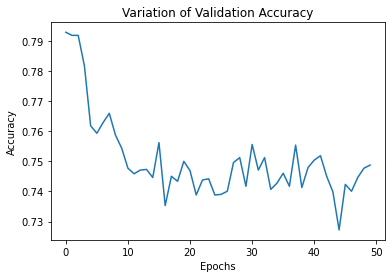

In [177]:
#Validation accuracy is showing a converging trend but is yet to reach convergence
print('Average validation accuracy: ',np.round(100*np.average(lstm_history.history['val_accuracy']),2),'%')
print('Average training accuracy: ',np.round(100*np.average(lstm_history.history['accuracy']),2),'%')
plt.figure()
plt.plot(lstm_history.history['val_accuracy'],label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Variation of Validation Accuracy')
plt.show()